In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import requests
url_base = 'http://newyork.craigslist.org/search/brk/aap'
params = dict(bedrooms=1)
rsp = requests.get(url_base, params=params)

In [3]:
print(rsp.url)
print(rsp.text[:500])

from bs4 import BeautifulSoup as bs4

# BS4 can quickly parse our text, make sure to tell it that you're giving html
html = bs4(rsp.text, 'html.parser')

# BS makes it easy to look through a document
print(html.prettify()[:1000])

http://newyork.craigslist.org/search/brk/aap?bedrooms=1
<!DOCTYPE html>
<html class="no-js"><head>
<title>new york all apartments - craigslist</title>
<meta name="description" content="new york all apartments  - craigslist">
<link rel="canonical" href="https://newyork.craigslist.org/search/brk/aap">
<link rel="alternate" type="application/rss+xml" href="https://newyork.craigslist.org/search/brk/aap?bedrooms=1&amp;format=rss" title="RSS feed for craigslist | new york all apartments  - craigslist ">
<link rel="next" href="https://newyork.craigslist.org
<!DOCTYPE html>
<html class="no-js">
 <head>
  <title>
   new york all apartments - craigslist
  </title>
  <meta content="new york all apartments  - craigslist" name="description">
   <link href="https://newyork.craigslist.org/search/brk/aap" rel="canonical">
    <link href="https://newyork.craigslist.org/search/brk/aap?bedrooms=1&amp;format=rss" rel="alternate" title="RSS feed for craigslist | new york all apartments  - craigslist " type

In [4]:
apts = html.find_all('p', attrs={'class': 'row'})
print(len(apts))

100


In [5]:
this_appt = apts[15]
print(this_appt.prettify())

<p class="row" data-pid="5369033774">
 <a class="i" data-ids="0:00w0w_1tEMkygUbIv,0:00J0J_chJoT3MLp1,0:01111_3WqIEemsqvV,0:00i0i_I3kWFnlpYT,0:01616_iCazk3IVkhq,0:00303_lKqPmxX5MMA,0:00c0c_oiMmHD0zzx,0:00E0E_cFKwN7f3Fi,0:00i0i_hUafx5mTi4y" href="/brk/abo/5369033774.html">
 </a>
 <span class="txt">
  <span class="star">
  </span>
  <span class="pl">
   <time datetime="2015-12-28 08:34" title="Mon 28 Dec 08:34:34 AM">
    Dec 28
   </time>
   <a class="hdrlnk" data-id="5369033774" href="/brk/abo/5369033774.html">
    NEWLY RENOVATED SUNNY 3BR/ LAUNDRY ROOM/ C,J,Z TRAINS
   </a>
  </span>
  <span class="l2">
   <span class="price">
    $2345
   </span>
   <span class="housing">
    / 3br -
   </span>
   <span class="pnr">
    <small>
     (BED STUY BEDSTUY)
    </small>
    <span class="px">
     <span class="p">
      pic
      <span class="maptag" data-pid="5369033774">
       map
      </span>
     </span>
    </span>
   </span>
  </span>
  <span class="js-only banish-unbanish no-mobile

In [6]:
size = this_appt.findAll(attrs={'class': 'housing'})[0].text
print(size)

/ 3br - 


In [7]:

def find_size_and_brs(size):
    split = size.strip('/- ').split(' - ')
    if len(split) == 2:
        n_brs = split[0].replace('br', '')
        this_size = split[1].replace('ft2', '')
    elif 'br' in split[0]:
        # It's the n_bedrooms
        n_brs = split[0].replace('br', '')
        this_size = np.nan
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].replace('ft2', '')
        n_brs = np.nan
    return float(this_size), float(n_brs)
this_size, n_brs = find_size_and_brs(size)

In [8]:
this_time = this_appt.find('time')['datetime']
this_time = pd.to_datetime(this_time)
this_price = float(this_appt.find('span', {'class': 'price'}).text.strip('$'))
this_title = this_appt.find('a', attrs={'class': 'hdrlnk'}).text
print('\n'.join([str(i) for i in [this_size, n_brs, this_time, this_price, this_title]]))

nan
3.0
2015-12-28 08:34:00
2345.0
NEWLY RENOVATED SUNNY 3BR/ LAUNDRY ROOM/ C,J,Z TRAINS


In [22]:
loc_prefixes = ['brk', 'mnh', 'que']

In [23]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

def find_times(results):
    times = []
    for rw in apts:
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

In [28]:
# Now loop through all of this and store the results
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily
search_indices = np.arange(0, 300, 100)
for loc in loc_prefixes:
    print loc
    for i in search_indices:
        url = 'http://newyork.craigslist.org/search/{0}/aap'.format(loc)
        resp = requests.get(url, params={'bedrooms': 1, 's': i})
        txt = bs4(resp.text, 'html.parser')
        apts = txt.findAll(attrs={'class': "row"})
        
        # Find the size of all entries
        size_text = [rw.findAll(attrs={'class': 'housing'})[0].text
                     for rw in apts]
        sizes_brs = [find_size_and_brs(stxt) for stxt in size_text]
        sizes, n_brs = zip(*sizes_brs)  # This unzips into 2 vectors
     
        # Find the title and link
        title = [rw.find('a', attrs={'class': 'hdrlnk'}).text
                      for rw in apts]
        links = [rw.find('a', attrs={'class': 'hdrlnk'})['href']
                 for rw in apts]
        
        # Find the time
        time = [pd.to_datetime(rw.find('time')['datetime']) for rw in apts]
        price = find_prices(apts)
        
        # We'll create a dataframe to store all the data
        data = np.array([time, price, sizes, n_brs, title, links])
        col_names = ['time', 'price', 'size', 'brs', 'title', 'link']
        df = pd.DataFrame(data.T, columns=col_names)
        df = df.set_index('time')
        
        # Add the location variable to all entries
        df['loc'] = loc
        results.append(df)
        
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

brk
mnh
que


In [29]:
results[['price', 'size', 'brs']] = results[['price', 'size', 'brs']].convert_objects(convert_numeric=True)

In [30]:
results.head()

,price,size,brs,title,link,loc
time,,,,,,
2015-12-28 08:52:00,2300,NaN,1,*STELLAR-LARGE 1.5 BR-BRIGHT-OPTIMUS PRIME GRE...,/brk/fee/5377364895.html,brk
2015-12-28 08:51:00,2495,NaN,3,GREAT DEAL**RENOVATED 3 BR*NEXT TO PRATT**WONT...,/brk/abo/5366067757.html,brk
2015-12-28 08:50:00,2495,NaN,3,BUSHWICK SUPER MODERN 3 BR APT~HIGH END~GREAT ...,/brk/abo/5343733017.html,brk
2015-12-28 08:50:00,2590,NaN,3,"THE 3,4,5 TRAIN --AMAZING 3BR/1BATH HUGE SPACE...",/brk/abo/5377307727.html,brk
2015-12-28 08:50:00,2180,NaN,1,1 Bedroom/1 Bathroom for $2180!,/brk/abo/5377303134.html,brk


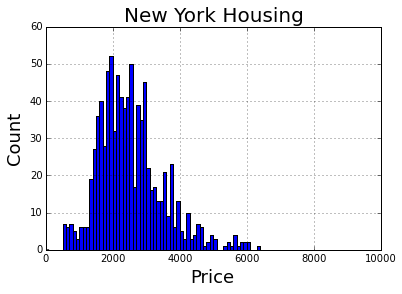

In [32]:
ax = results.hist('price', bins=np.arange(0, 10000, 100))[0, 0]
ax.set_title('New York Housing', fontsize=20)
ax.set_xlabel('Price', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

In [33]:
import string
use_chars = string.ascii_letters +\
    ''.join([str(i) for i in range(10)]) +\
    ' /\.'
results['title'] = results['title'].apply(
    lambda a: ''.join([i for i in a if i in use_chars]))

results.to_csv('../data/craigslist_results.csv')